In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
from itertools import combinations
import allel
import pandas as pd
from pathlib import Path

## Steps

1. Load in distance matrix and compute x/y

2. Drop samples that failed sample QC

3. For each set of replicates assert that the diff is low\*.
Exclude both members of pair if false.
Exclude one if true.

4. For each pair of non replicates assert the dist is not low\*.
Exclude pair if false
No action if 

\* low definition tbc.

In [3]:
threshold = 0.0005
sampleset = "AG1000G-UG"

In [4]:
tracking_dir = Path("/home/jovyan/vector-ops/tracking") / sampleset

In [5]:
df = pd.read_csv("/gcs/observatory/manifest").rename({"sample_name": "derived_sample_id"}, axis=1)
df["FILTER_replicateqc"] = "PASS"
df["FILTER_isreplicate"] = "PASS"

In [6]:
df.head()

,derived_sample_id,FILTER_replicateqc,FILTER_isreplicate
0,AC0007-C,PASS,PASS
1,AC0007-Cx,PASS,PASS
2,AC0008-C,PASS,PASS
3,AC0009-C,PASS,PASS
4,AC0009-Cx,PASS,PASS


In [7]:
orig_samples = pd.read_csv(tracking_dir / 'original_samples.tsv', sep="\t")
deri_samples = pd.read_csv(tracking_dir / 'derived_samples.tsv', sep="\t")

In [8]:
a = np.load("replicate-qc-AG1000G-UG.npz")

In [9]:
list(a.keys())

['cityblock', 'nsites']

In [10]:
dist = a["cityblock"].sum(axis=0) / a["nsites"].sum(axis=0)

In [12]:
# assume this is ok for now. Normally use the manifest
samples = df["derived_sample_id"].tolist()

In [13]:
pairs = list(combinations(range(len(samples)), 2))
npairs = len(pairs)
del pairs
del npairs

In [14]:
qc_filters = pd.read_csv(tracking_dir / "wgs_qc" / "qc_filters.tsv", sep="\t", index_col=0)

In [15]:
passing_samples = (qc_filters == "PASS").all(axis=1)
passing_samples.name = "PASS"

In [16]:
pass_df = passing_samples.reset_index().query("PASS")

In [17]:
pairs_pass = list(combinations(pass_df.index, 2))

In [18]:
same_list = []
diff_list = []

for i, j in pairs_pass:
    ix = allel.condensed_coords(i, j, len(samples))
    if samples[i][:8] == samples[j][:8]:
        
        same_list.append(dist[ix])
        if dist[ix] >= threshold:
            print(i, j, "failed", "expected pair", dist[ix])
            df.loc[i, "FILTER_replicateqc"] = "FAIL"
            df.loc[j, "FILTER_replicateqc"] = "FAIL"
        else:
            df.loc[j, "FILTER_isreplicate"] = "FAIL"
            
    else:
        diff_list.append(dist[ix])
        if dist[ix] < threshold:
            print(i, j, "failed", "unexpected closeness", dist[ix])
            df.loc[i, "FILTER_replicateqc"] = "FAIL"
            df.loc[j, "FILTER_replicateqc"] = "FAIL"        

235 236 failed expected pair 0.0005147397701882325


In [19]:
(df == "FAIL").sum(axis=0)

derived_sample_id      0
FILTER_replicateqc     2
FILTER_isreplicate    66
dtype: int64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


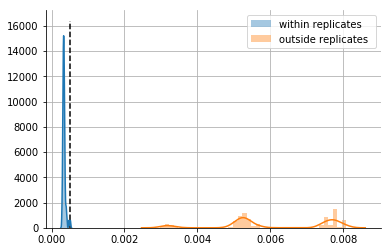

In [20]:
f, ax = plt.subplots()
ax.grid(True)
sns.despine(ax=ax)
sns.distplot(np.array(same_list), ax=ax, label="within replicates")
sns.distplot(np.array(diff_list), ax=ax, label="outside replicates ")
ax.vlines([threshold], *ax.get_ylim(), linestyles="dashed")
ax.legend()

In [21]:
df.head()

,derived_sample_id,FILTER_replicateqc,FILTER_isreplicate
0,AC0007-C,PASS,PASS
1,AC0007-Cx,PASS,FAIL
2,AC0008-C,PASS,PASS
3,AC0009-C,PASS,PASS
4,AC0009-Cx,PASS,FAIL


In [22]:
df.to_csv(tracking_dir / 'wgs_qc/replicate_qc_filters.tsv', sep='\t', index=True)